In [1]:
import time
import tensorwatch as tw

import gym
import math
import random
import cv2
import numpy as np
import collections
import matplotlib
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T

NOTEBOOK_MODE = True
if NOTEBOOK_MODE:
    from tqdm.notebook import tqdm
else:
    from tqdm import tqdm


env = gym.make('Pong-v0').unwrapped
if NOTEBOOK_MODE:
    # set up matplotlib to open viewing window
    is_ipython = 'inline' in matplotlib.get_backend()
    if is_ipython:
        from IPython import display

    plt.ion()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
class WarpFrame(gym.ObservationWrapper):
    def __init__(self, env, width=84, height=84, grayscale=True, dict_space_key=None):
        """
        Warp frames to 84x84 as done in the Nature paper and later work.
        If the environment uses dictionary observations, `dict_space_key` can be specified which indicates which
        observation should be warped.
        """
        super().__init__(env)
        self._width = width
        self._height = height
        self._grayscale = grayscale
        self._key = dict_space_key
        if self._grayscale:
            num_colors = 1
        else:
            num_colors = 3

        new_space = gym.spaces.Box(
            low=0,
            high=255,
            shape=(self._height, self._width, num_colors),
            dtype=np.uint8,
        )
        if self._key is None:
            original_space = self.observation_space
            self.observation_space = new_space
        else:
            original_space = self.observation_space.spaces[self._key]
            self.observation_space.spaces[self._key] = new_space
        assert original_space.dtype == np.uint8 and len(original_space.shape) == 3

    def observation(self, obs):
        if self._key is None:
            frame = obs
        else:
            frame = obs[self._key]

        if self._grayscale:
            frame = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
        frame = cv2.resize(
            frame, (self._width, self._height), interpolation=cv2.INTER_AREA
        )
        if self._grayscale:
            frame = np.expand_dims(frame, -1)

        if self._key is None:
            obs = frame
        else:
            obs = obs.copy()
            obs[self._key] = frame
        return obs

In [4]:
WarpFrame(env).observation(env.render())

error: OpenCV(4.1.2) /io/opencv/modules/imgproc/src/color.simd_helpers.hpp:92: error: (-2:Unspecified error) in function 'cv::impl::{anonymous}::CvtHelper<VScn, VDcn, VDepth, sizePolicy>::CvtHelper(cv::InputArray, cv::OutputArray, int) [with VScn = cv::impl::{anonymous}::Set<3, 4>; VDcn = cv::impl::{anonymous}::Set<1>; VDepth = cv::impl::{anonymous}::Set<0, 2, 5>; cv::impl::{anonymous}::SizePolicy sizePolicy = (cv::impl::<unnamed>::SizePolicy)2u; cv::InputArray = const cv::_InputArray&; cv::OutputArray = const cv::_OutputArray&]'
> Invalid number of channels in input image:
>     'VScn::contains(scn)'
> where
>     'scn' is 1


In [ ]:
watcher = tw.Watcher() # tensorwatch watcher (Microsoft Tensorwatch)

In [ ]:
env.unwrapped.get_action_meanings()

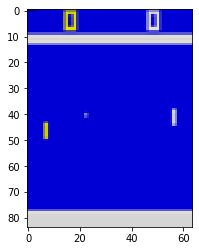

In [8]:
resize = T.Compose([T.ToPILImage(),
                    T.Resize(64, interpolation=Image.CUBIC),
                    T.ToTensor()])

def get_screen():
    # convert to channel,h,w dimensions
    screen = env.render(mode='rgb_array').transpose((2, 0, 1))
    
    # erase background
    screen[screen == 72] = 0 
    screen[screen == 74] = 0 
    screen[screen == 144] = 0 
    screen[screen != 0] = 213
    screen = np.ascontiguousarray(screen, dtype=np.float32) / 255
    
    screen = torch.from_numpy(screen)
    
    # convert to batch,channel,h,w dimensions
    return resize(screen).unsqueeze(0).to(device)

if NOTEBOOK_MODE:
    env.reset()
    # run game for a bit to load the ball and opponent paddle
    for i in range(50):
        env.step(0)
    plt.figure()
    plt.imshow(get_screen().cpu().squeeze(0).permute(1, 2, 0).numpy(),
               interpolation='none')
    plt.show()

In [ ]:
learning_rate = 0.0005
gamma = 0.98
buffer_limit = 50000
batch_size = 32

In [7]:
get_screen().shape

NameError: name 'get_screen' is not defined

In [ ]:
"""
store previous sequence-action pairs to decorrelate temporal locality
transitions are composed of state, action, reward, next_state, and done_mask
"""
x_tmp = []
class ReplayBuffer():
    def __init__(self):
        self.buffer = collections.deque(maxlen=buffer_limit)
    
    def put(self, transition):
        self.buffer.append(transition)
        
    def sample(self, n):
        mini_batch = random.sample(self.buffer, n)
        s_lst, a_lst, r_lst, s_prime_lst, done_mask_lst = [], [], [], [], []
        
        for transition in mini_batch:
            s, a, r, s_prime, done_mask = transition
            s_lst.append(s)
            a_lst.append([a])
            r_lst.append([r])
            s_prime_lst.append(s_prime)
            done_mask_lst.append([done_mask])
            
        return  torch.cat(s_lst).to(device), \
                torch.tensor(a_lst).to(device), \
                torch.tensor(r_lst).to(device),\
                torch.cat(s_prime_lst).to(device), \
                torch.tensor(done_mask_lst).to(device)
    
    def size(self):
        return len(self.buffer)

In [ ]:
_, _, h, w = get_screen().shape

class Qnet(nn.Module):
    def __init__(self):
        super(Qnet, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=8, stride=4)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, stride=1)
        self.bn3 = nn.BatchNorm2d(64)
        
        # Number of Linear input connections depends on output of conv2d layers
        # and therefore the input image size, so compute it.
        def conv2d_size_out(size, kernel_size = 4, stride = 2):
            return (size - (kernel_size - 1) - 1) // stride  + 1
        convw = conv2d_size_out(conv2d_size_out(conv2d_size_out(w, 8, 4), 4, 2), 3, 1)
        convh = conv2d_size_out(conv2d_size_out(conv2d_size_out(h, 8, 4), 4, 2), 3, 1)
        linear_input_size = convw * convh * 64
        self.head = nn.Sequential(
            nn.Linear(linear_input_size, 256),
            nn.ReLU(),
            nn.Linear(256, 2)
        )
        
    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        return self.head(x.view(x.size(0), -1))
    
    # action is either random or max probability estimated by Qnet
    def sample_action(self, obs, epsilon):
        out = self.forward(obs) # don't need if random action 
        coin = random.random()
        if coin < epsilon:
            return random.randint(0,1)
        else:
            return out.argmax().item()

In [ ]:
def train(q, q_target, memory, optimizer):
    s,a,r,s_prime,done_mask = memory.sample(batch_size)

    q_out = q(s)
    # collect output from the chosen action dimension
    q_a = q_out.gather(1,a) 

    # most reward we get in next state s_prime
    max_q_prime = q_target(s_prime).max(1)[0].unsqueeze(1)
    target = r + gamma * max_q_prime * done_mask
    # how much is our policy different from the true target 
    loss = F.smooth_l1_loss(q_a, target)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

In [ ]:
def main(num_episodes, watcher):
    env = gym.make('Pong-v0')
    q = Qnet().to(device)
    q_target = Qnet().to(device)
    q_target.load_state_dict(q.state_dict())
    memory = ReplayBuffer()
    
    save_interval = 250
    print_interval = 1
    score = 0.0
    optimizer = optim.Adam(q.parameters(), lr=learning_rate)
    
    for episode in tqdm(range(1,num_episodes+1)):
        # anneal 8% to 1% over training
        epsilon = max(0.01, 0.08 - 0.01*(episode/200))
        env.reset()
        current_s = get_screen()
        done = False
        last_s = get_screen()
        current_s = get_screen()
        s = last_s - current_s
        episode_score = 0
        while not done:
            a = q.sample_action(s, epsilon)
            # first variable would be s_prime but we have get_screen
            _, r, done, info = env.step(a + 2)
            last_s = current_s
            current_s = get_screen()
            s_prime = last_s - current_s
            
            done_mask = 0.0 if done else 1.0
            memory.put((s,a,r/100.,s_prime,done_mask))
            s = s_prime
            
            score += r
            episode_score += r
            if done:
                break
                
            if memory.size()>2000:
                train(q, q_target, memory, optimizer)
        watcher.observe(score = episode_score)
        if episode%print_interval==0 and episode!=0:
            q_target.load_state_dict(q.state_dict())
            print("n_episode : {}, Average Score : {:.1f}, Episode Score : {:.1f}, n_buffer : {}, eps : {:.1f}%".format(
                episode, score/episode, episode_score, memory.size(), epsilon*100))
            
        if episode%save_interval==0 and episode!=0:
            # save model weights 
            torch.save(q_target.state_dict(), 'checkpoints/target_bot_%s.pt' % episode)
            torch.save(q.state_dict(), 'checkpoints/policy_bot_%s.pt' % episode)
    # save final model weights 
    torch.save(q_target.state_dict(), 'checkpoints/target_bot_final.pt')
    torch.save(q.state_dict(), 'checkpoints/policy_bot_final.pt')

In [ ]:
main(4, watcher)

In [ ]:
q = Qnet().to(device)
q.load_state_dict(torch.load('checkpoints/target_bot_final.pt'))
q.eval()

In [ ]:
# record trained agent gameplay

frames = []

env.reset()
current_s = get_screen()
done = False
last_s = get_screen()
current_s = get_screen()
s = last_s - current_s
epsilon = 0.0
while not done:
    a = q.sample_action(s, epsilon) + 2
    
    # use environment's frame instead of preprocessed get_screen()
    next_frame, _, done, info = env.step(a)
    frames.append(next_frame)
    last_s = current_s
    current_s = get_screen()
    s_prime = last_s - current_s

    done_mask = 0.0 if done else 1.0
    s = s_prime
    if done:
        break

In [ ]:
# save game to video 
height, width = frames[0].shape[:2] 

writer = cv2.VideoWriter_fourcc('M','J','P','G')
fps = 30
video_file = 'playback.avi'
out = cv2.VideoWriter(video_file, writer, fps, (width,height))
for frame in frames:
    out.write(frame)

out.release()